In [386]:
import sqlalchemy as db
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

%matplotlib inline
%config InLineBackend.figure_format='retina'

In [342]:
user = 'wnbentley'
password = 'December9'
database = 'postgresql://{}:{}@bsds200.c3ogcwmqzllz.us-east-1.rds.amazonaws.com/bsdsclass'.format(user, password)

engine = db.create_engine(database)

In [343]:
query = """Select *
    From
        (Select 
            count(name) as observation_ct, max(tweets) as tweets, max(following) as following, 
            max(followers) as followers, max(likes) as likes, max(media) as media, 
            max(verified) as verified, username 
        From 
            song_pop.twitter
        where username in (select distinct username from song_pop.artist_socials) 
        group by username) as LHS
    Inner Join    
        (select username, artist_id, follower_count as Spotify_follower_ct
        from 
            song_pop.artist_socials) as RHS
    on LHS.username=RHS.username;"""
with engine.connect() as con:
    #result = con.execute(query)
    q2data = pd.read_sql(query, con)

In [344]:
print(q2data.columns)
print(q2data.shape)
q2data.head(10)

Index(['observation_ct', 'tweets', 'following', 'followers', 'likes', 'media',
       'verified', 'username', 'username', 'artist_id', 'spotify_follower_ct'],
      dtype='object')
(38021, 11)


,observation_ct,tweets,following,followers,likes,media,verified,username,username,artist_id,spotify_follower_ct
0,2,5549.0,1046.0,3898.0,20089.0,271,0.0,tailsxbeats,tailsxbeats,007nYTXRhZJUZGH7ct5Y3v,7789
1,1,12375.0,143.0,516.0,1384.0,1416,0.0,Flasht_pmg,Flasht_pmg,007pt2ONVI5ZWisox0DoP3,99
2,1,596.0,377.0,227.0,641.0,113,0.0,fabianluttenb,fabianluttenb,00A9Xt6NyGD5bldz9OnCbe,1578
3,1,675.0,109.0,23449.0,160.0,70,0.0,Vienna_Phil,Vienna_Phil,003f4bk13c6Q3gAUXv7dGJ,68964
4,2,2670.0,250.0,1955.0,1968.0,296,1.0,mwc_music,mwc_music,00b3RKsk2pv5VWSnYAKW8u,9489
5,2,10883.0,704.0,6997.0,2449.0,1183,1.0,jimmoray,jimmoray,00baC9BEnC6lhOdSF6dYC8,2607
6,2,33.0,3.0,20.0,35.0,4,0.0,m11sound,m11sound,00BAIPDOmSHZblGig3Tnwe,182
7,2,493.0,29.0,1906.0,1560.0,206,0.0,PLANETmusicau,PLANETmusicau,00BZcQJXuUSMVEB9FVqgUl,4494
8,1,61.0,162.0,74.0,1.0,54,0.0,quietquestmusic,quietquestmusic,00cCHU2E098Qnj8RvxumFn,91
9,1,579.0,42.0,2277.0,509.0,110,0.0,Suzanemusique,Suzanemusique,00CTomLgA78xvwEwL0woWx,25045


In [345]:
q2data.isnull().sum()

observation_ct           0
tweets                 120
following              120
followers              120
likes                  120
media                  120
verified               120
username                 0
username                 0
artist_id                0
spotify_follower_ct      0
dtype: int64

In [346]:
# Remove all nulls
q2data = q2data.dropna()

In [347]:
popular_threshold = q2data['spotify_follower_ct'].quantile(0.90)
print(popular_threshold)

59523.0


In [348]:
popular_threshold

(q2data.spotify_follower_ct <= popular_threshold)

0         True
1         True
2         True
3        False
4         True
         ...  
38016     True
38017     True
38018     True
38019     True
38020     True
Name: spotify_follower_ct, Length: 37901, dtype: bool

In [349]:
# Creating label column popular/not popular (0 or 1)
q2data['popular'] = 1
q2data.loc[(q2data.spotify_follower_ct <= popular_threshold), 'popular'] = 0
q2data.head()

,observation_ct,tweets,following,followers,likes,media,verified,username,username,artist_id,spotify_follower_ct,popular
0,2,5549.0,1046.0,3898.0,20089.0,271,0.0,tailsxbeats,tailsxbeats,007nYTXRhZJUZGH7ct5Y3v,7789,0
1,1,12375.0,143.0,516.0,1384.0,1416,0.0,Flasht_pmg,Flasht_pmg,007pt2ONVI5ZWisox0DoP3,99,0
2,1,596.0,377.0,227.0,641.0,113,0.0,fabianluttenb,fabianluttenb,00A9Xt6NyGD5bldz9OnCbe,1578,0
3,1,675.0,109.0,23449.0,160.0,70,0.0,Vienna_Phil,Vienna_Phil,003f4bk13c6Q3gAUXv7dGJ,68964,1
4,2,2670.0,250.0,1955.0,1968.0,296,1.0,mwc_music,mwc_music,00b3RKsk2pv5VWSnYAKW8u,9489,0


In [350]:
print(q2data.popular.value_counts())
print(3790/(3790+34111))

0    34111
1     3790
Name: popular, dtype: int64
0.09999736154718873


Question: #2 How much does an artist's Twitter presence impact their popularity?

In [352]:
# Looking at columns available
q2data.columns

Index(['observation_ct', 'tweets', 'following', 'followers', 'likes', 'media',
       'verified', 'username', 'username', 'artist_id', 'spotify_follower_ct',
       'popular'],
      dtype='object')

In [297]:
q2data = q2data.convert_dtypes()
q2data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37901 entries, 0 to 38020
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   observation_ct       37901 non-null  Int64 
 1   tweets               37901 non-null  Int64 
 2   following            37901 non-null  Int64 
 3   followers            37901 non-null  Int64 
 4   likes                37901 non-null  Int64 
 5   media                37901 non-null  string
 6   verified             37901 non-null  Int64 
 7   username             37901 non-null  string
 8   username             37901 non-null  string
 9   artist_id            37901 non-null  string
 10  spotify_follower_ct  37901 non-null  Int64 
 11  popular              37901 non-null  Int64 
dtypes: Int64(8), string(4)
memory usage: 4.0 MB


In [298]:
# Making the 'verified' column a category
q2data['verified'] = q2data['verified'].astype('category')
q2data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37901 entries, 0 to 38020
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   observation_ct       37901 non-null  Int64   
 1   tweets               37901 non-null  Int64   
 2   following            37901 non-null  Int64   
 3   followers            37901 non-null  Int64   
 4   likes                37901 non-null  Int64   
 5   media                37901 non-null  string  
 6   verified             37901 non-null  category
 7   username             37901 non-null  string  
 8   username             37901 non-null  string  
 9   artist_id            37901 non-null  string  
 10  spotify_follower_ct  37901 non-null  Int64   
 11  popular              37901 non-null  Int64   
dtypes: Int64(7), category(1), string(4)
memory usage: 3.8 MB


In [299]:
# Selecting feature columns 
x = q2data.loc[:, ['tweets', 'following', 'followers', 
                'likes', 'media', 'verified', 'spotify_follower_ct']] 
x = x.dropna()

In [300]:
# Selecting target column
y = q2data.loc[:, 'popular']

y = y.dropna()

In [301]:
# create training and testing vars
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(30320, 7) (30320,)
(7581, 7) (7581,)


In [306]:
# Cast data types as integers
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [327]:
# Create model
model = LogisticRegression(multi_class='ovr' , max_iter=1000, random_state=10)

In [328]:
# fit model
model = model.fit(x_train.values, y_train.values)

In [353]:
# Predict model
y_pred = model.predict(x_test)

In [354]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9990766389658357


In [355]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6855
           1       0.99      1.00      1.00       726

    accuracy                           1.00      7581
   macro avg       1.00      1.00      1.00      7581
weighted avg       1.00      1.00      1.00      7581



In [356]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Absolute Error: 0.0009233610341643582
Mean Squared Error: 0.0009233610341643582


In [357]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[6849    6]
 [   1  725]]


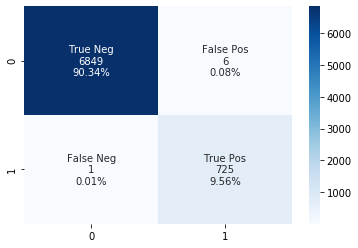

In [375]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')